In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
from pysas import World, waveread

In [2]:
signal, samplingrate, _ = waveread("test/cmu_arctic/arctic_a0001.wav")

In [3]:
world = World(samplingrate)

In [4]:
f0,spec_mat,c = world.analyze(signal)

In [5]:
len(f0)

648

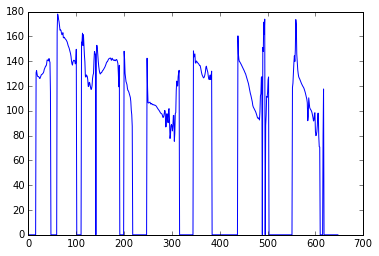

In [6]:
plt.plot(f0)

In [7]:
spec = spec_mat[300]

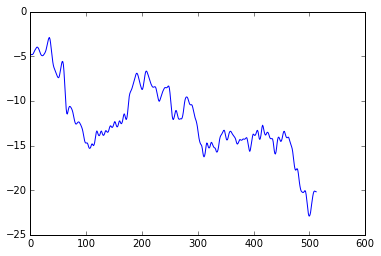

In [8]:
plt.plot(np.log(spec))

In [9]:
from pysas.mcep import spec2mcep, mcep2spec, mcep2coef, coef2mcep, estimate_alpha

In [10]:
alpha = round(estimate_alpha(samplingrate), 3)
alpha

0.41

In [11]:
mcep = spec2mcep(spec, 24, alpha)

In [12]:
spec2 = mcep2spec(mcep, alpha, world.fftsize())

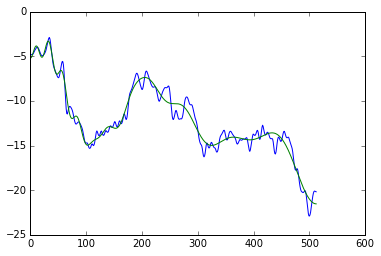

In [13]:
plt.plot(np.log(spec))
plt.plot(np.log(spec2[:world.envelopesize()]))

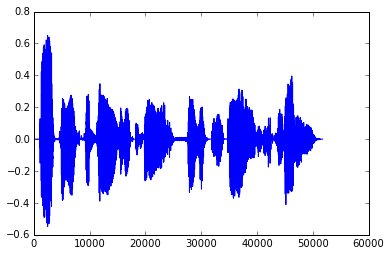

In [14]:
plt.plot(signal)

In [15]:
out = world.synthesis(f0,spec_mat,c)

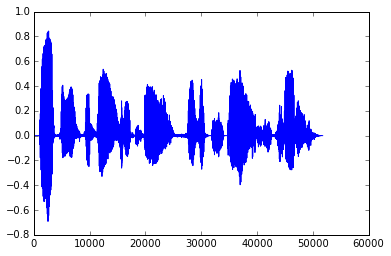

In [16]:
plt.plot(out)

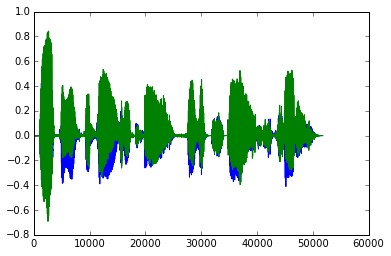

In [17]:
plt.plot(signal)
plt.plot(out)

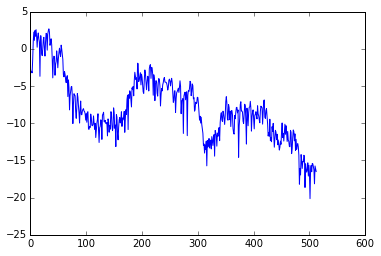

In [18]:
i = 80* 300
windowsize = 1024
sig = signal[i:i+windowsize] * np.hanning(windowsize)
power_spectrum = (np.absolute(np.fft.fft(sig)) ** 2)[:(windowsize>>1) + 1]
plt.plot(np.log(power_spectrum))

In [19]:
fft_mcep = spec2mcep(power_spectrum, 20, alpha)
reconst_pspec = mcep2spec(fft_mcep, alpha, windowsize)

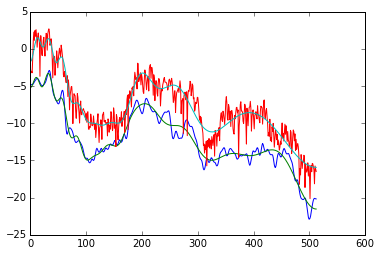

In [20]:
plt.plot(np.log(spec))
plt.plot(np.log(spec2))
plt.plot(np.log(power_spectrum))
plt.plot(np.log(reconst_pspec))

In [21]:
coef = mcep2coef(fft_mcep, alpha)
reconst_mcep = coef2mcep(coef, alpha)

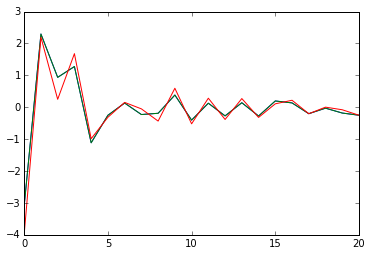

In [22]:
plt.plot(fft_mcep)
plt.plot(reconst_mcep)
plt.plot(coef)

In [23]:
from pysas.excite import ExcitePulse

In [24]:
ep = ExcitePulse(16000, 80, False)

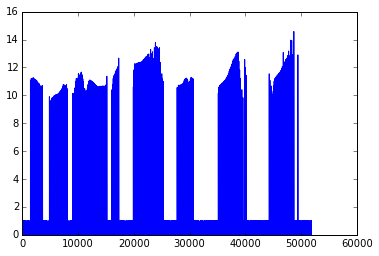

In [25]:
plt.plot(ep.gen(f0))

In [26]:
from pysas.synthesis_filter.mlsa import MLSAFilter

In [27]:
mlsa = MLSAFilter(40, 0.41, 5)

In [28]:
pulse = ep.gen(f0)

In [29]:
from pysas.mcep import spec2mcep_from_matrix

In [30]:
mcep_mat = spec2mcep_from_matrix(spec_mat, 40, 0.41)

In [31]:
coef_mat = []
for i in range(mcep_mat.shape[0]):
    coef_mat.append(mcep2coef(mcep_mat[i], 0.41))
coef_mat = np.array(coef_mat)

In [32]:
from pysas.synthesis_filter.synthesis import Synthesis

In [33]:
syn = Synthesis(80, mlsa)

In [34]:
synth = syn.synthesis(pulse, coef_mat)

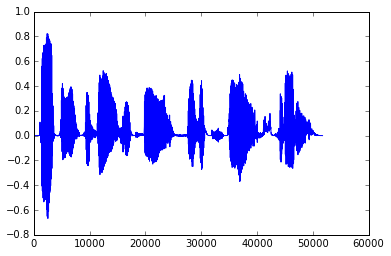

In [35]:
plt.plot(synth[100:])

In [310]:
params = (1, 2, 16000, len(synth), 'NONE', 'not compressed')

In [311]:
wf=wave.open("out.wav",'wb')

In [312]:
wf.setparams(params)

In [313]:
s = np.int16(synth[100:] * 32767.0).tostring()

In [314]:
wf.writeframes(s)

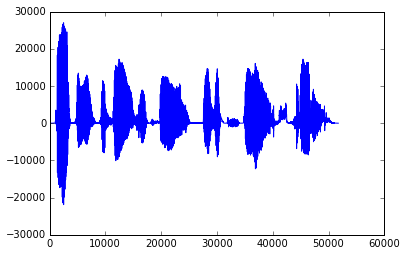

In [315]:
plt.plot(synth[100:] * 32767.0)

In [37]:
%timeit synth = syn.synthesis(pulse, coef_mat)

1 loops, best of 3: 1.17 s per loop
